# Getting Started with the srsinst.sr860 Python Driver

This Jupyter Notebook follows along with the Getting Started chapter of the SR860 Operation Manual, and should help you get started using our srsinst.sr860 Python Instrument driver to control your lock-in amplifier remotely

In [2]:
from srsinst.sr860 import SR860

# only required for USB or GPIB communication
import pyvisa as visa 

# Establishing a Connection

You only need to execute one of the following instantiation and connection cells (to connect via the 'serial', 'vxi11', or 'visa' (USB or GPIB) interface), depending on the connection you have made to your instrument. 

Make sure to adjust the address of your device appropriately.

In [3]:
lockin = SR860('serial', 'COM7')

In [8]:
lockin = SR860('vxi11', '172.25.129.22')

Stanford_Research_Systems,SR860,002819,v1.51


Or establish a connection with USB or GPIB, both of which utilize `PyVisa` and use the `'visa'` string to make the connection

In [4]:
visa.ResourceManager().list_resources()

('USB0::0xB506::0x2000::002819::INSTR',
 'ASRL3::INSTR',
 'ASRL5::INSTR',
 'ASRL6::INSTR',
 'GPIB0::4::INSTR')

In [6]:
lockin = SR860('visa', 'GPIB0::4::INSTR')

In [10]:
lockin = SR860('visa', 'USB0::0xB506::0x2000::002819::INSTR')

Once the connection is established, this notebook is designed to be executed top-to-bottom.

Confirm you have connected to the instrument and can communicate!

In [7]:
lockin.check_id()

('SR860', '002819', 'v1.51')

In [12]:
print(lockin.get_status())

Frequency: 1.000000e+03 Hz
 Phase: 0.118317 deg
 Amplitude: 0.0500 V
 DC level: 0.0000 V
 Harmonic: 1

OK


# Inspect the lockin available components, commands, and methods

In [67]:
lockin.dir.keys()

dict_keys(['components', 'commands', 'methods'])

In [68]:
lockin.dir['components']

{'ref': 'instance of Reference',
 'signal': 'instance of Signal',
 'output': 'instance of Output',
 'aux': 'instance of Aux',
 'auto': 'instance of Auto',
 'display': 'instance of Display',
 'chart': 'instance of Chart',
 'fft': 'instance of FFT',
 'scan': 'instance of Scan',
 'data': 'instance of DataTransfer',
 'capture': 'instance of DataCapture',
 'stream': 'instance of DataStream',
 'system': 'instance of System',
 'interface': 'instance of Interface',
 'status': 'instance of Status'}

In [69]:
# (no available commands at the top instrument level)
lockin.dir['commands']

{}

In [70]:
lockin.dir['methods']

['connect',
 'check_id',
 'reset',
 'get_status',
 'disconnect',
 'is_connected',
 'set_term_char',
 'get_term_char',
 'send',
 'query_text',
 'query_int',
 'query_float',
 'get_available_interfaces',
 'get_info',
 'handle_command',
 'connect_with_parameter_string']

# Getting Started

Be sure to connect the lock-in's Sine Out to the Input A, as instructed in the Getting Started guide for "The Basic Lock-in"

Start with standard settings

In [15]:
lockin.reset()

## Sine Out Amplitude

In [16]:
lockin.ref.sine_out_amplitude

0.0

In [17]:
lockin.ref.sine_out_amplitude = 500e-3
lockin.ref.sine_out_amplitude

0.5

## Query measured values

First, learn about the "data" component. Just as the top-level lockin has a `dir` method, this can be used on any of the subcomponents to learn about the `commands` and `methods` therein.

In [18]:
lockin.data.dir

{'components': {},
 'commands': {'channel_config': ('DictIndexCommand', 'CDSP'),
  'channel_value': ('FloatIndexGetCommand', 'OUTR'),
  'value': ('FloatIndexGetCommand', 'OUTP')},
 'methods': ['get_values', 'get_channel_values']}

Then learn how to use the `value` command using the `get_command_info()` helper method.

In [19]:
lockin.data.get_command_info('value')

{'command class': 'FloatIndexGetCommand',
 'raw remote command': 'OUTP',
 'set_dict': None,
 'get_dict': None,
 'index_dict': {'X': 0,
  'Y': 1,
  'R': 2,
  'Theta': 3,
  'aux in 1': 4,
  'aux in 2': 5,
  'aux in 3': 6,
  'aux in 4': 7,
  'X noise': 8,
  'Y noise': 9,
  'aux out 1': 10,
  'aux out 2': 11,
  'phase': 12,
  'amplitude': 13,
  'DC level': 14,
  'int. freq.': 15,
  'ext. freq.': 16}}

Query individual values

In [20]:
lockin.data.value['X']

0.50329655409

In [21]:
lockin.data.value['Y']

-0.00049118528841

The above is equivalent to:

In [22]:
lockin.data.value[0]

0.50328469276

In [23]:
lockin.data.value[1]

-0.00049908139044

Query multiple values simultaneously

In [24]:
lockin.data.get_values('X','Y')

[0.50327980518, -0.00050187174929]

In [25]:
lockin.data.get_channel_values()

[0.50328660011, -0.00050557876239, 0.50328683853, -0.057556293905]

To determine what is returned in the list of values for `get_channel_values()`, we can use the `channel_config` command

In [26]:
ch0 = lockin.data.channel_config[0]
ch1 = lockin.data.channel_config[1]
ch2 = lockin.data.channel_config[2]
ch3 = lockin.data.channel_config[3]
print([ch0, ch1, ch2, ch3])

['X', 'Y', 'R', 'Theta']


## Phase and Frequency

First, query the phase. This is a "command", so we only need to provide the command name (no parentheses needed)

In [27]:
lockin.ref.phase

0.0

In [28]:
lockin.ref.auto_phase()

Note that `auto_phase()` is a *method* and not a *command*, so it requires the parentheses to execute. Following the `auto_phase()` method, the phase should have adjusted slightly.

In [29]:
lockin.ref.phase

-0.057948958129

In [30]:
lockin.ref.phase += 90
lockin.ref.phase

89.942050958

Following a phase rotation of 90deg, the signal should be shifted to Y

In [31]:
lockin.data.get_values('X','Y')

[-2.4314981601e-06, -0.50320702791]

In [32]:
lockin.ref.frequency = 1e3

## Signal Overload and Input Range

Reduce the output amplitude

In [33]:
lockin.ref.sine_out_amplitude = 5e-3

Fetch the input range before we make any changes to it. (The default should be 1 V)

In [34]:
lockin.signal.voltage_input_range

1.0

In [36]:
lockin.auto.set_range()
lockin.signal.voltage_input_range

0.01

Adjust the amplitude to intentionally cause an overload

In [37]:
lockin.ref.sine_out_amplitude = 50e-3

There are several ways to obtain the overload status

In [38]:
lockin.signal.strength_indicator

4

In [39]:
lockin.status.overload

16

During an input overload, the auto-range function simply selects the 1 V range

In [40]:
lockin.auto.set_range()
lockin.signal.voltage_input_range

1.0

Make sure the previous `auto.set_range()` has cleared the overload

In [42]:
lockin.status.overload

0

Once the overload has cleared, the auto-range can select the appropriate range

In [43]:
lockin.auto.set_range()
lockin.signal.voltage_input_range

0.1

In [44]:
lockin.signal.strength_indicator

3

## Sensitivity, Time Constant, and Filters

In [45]:
lockin.signal.time_constant

0.1

If you can't see the front panel, you can get a sense of the measurement noise be querying the X noise (or Y noise). Note that the lockin noise measurements require about 200 time constants to settle.   

Note: Because this section makes use of X noise measurements, quick execution of the cells in sequence one after the other may not give useful results (if cells are executed more quickly than the settling time of the noise measurement).

In [48]:
lockin.data.value['X noise']

2.7102961653e-08

In [49]:
lockin.signal.time_constant = 300e-6

In [50]:
lockin.data.value['X noise']

0.0090149240568

In [51]:
lockin.signal.filter_slope

6

In [52]:
lockin.signal.filter_slope = 24

In [53]:
lockin.data.value['X noise']

0.00015339632228

In [54]:
lockin.signal.filter_slope = 6

In [55]:
lockin.signal.sync_filter

'off'

In [56]:
lockin.signal.sync_filter = 'on'

In [57]:
lockin.data.value['X noise']

4.587489002e-07

# Performing a Measurement Scan

Let's say you want to automate data collection of measured voltage vs. DC offset (e.g. a so called differential resistance measurement: $dV/dI$ vs $I_\mathrm{dc}$).

The parameter values I've chosen here (for things like Time Constant, Sensitivity, etc.) are just guesses, and should not be interpreted as recommendations for your particular experiment.

It can be difficult to know what values to set everything to programatically, so it's often easiest to set up the measurement and make adjustments on the front panel to make sure things like Sensitivity, Input Range, Time Constant, and Filter Slope are set appropriately (no overloads, but making good use of the input range; relatively fast settling time so that measurements aren't unnecessarily long, but also not too noisy; etc.). 

In [58]:
import numpy as np
from time import sleep
import matplotlib.pyplot as plt

In [59]:
def set_time_constant(f_signal, N):
    """
    Sets the lockin time constant to the nearest
    valid setting for Tc > N * 1/(2*pi*f_signal)
    """

    valid_time_constants = list(lockin.signal.get_command_info('time_constant')['set_dict'].keys())
    tc = N*1/(2*np.pi*f_signal)
    tc_index = np.searchsorted(valid_time_constants, tc)
    tc = valid_time_constants[tc_index]
    print(f'Tc = {tc} s')
    lockin.signal.time_constant = tc
    

## Initialize the SR860

In [60]:
# Configure the Sine Out (excitation)
f_signal = 211.37
lockin.ref.frequency = f_signal
lockin.ref.phase = 0
lockin.ref.sine_out_amplitude = 50e-3
lockin.ref.sine_out_offset = 0.0

In [61]:
# Configure the Input Range, Sensitivity
lockin.signal.voltage_input_range = 0.1

In [62]:
# Configure the Time Constant and Filters
set_time_constant(f_signal, 40)

lockin.signal.filter_slope = 6
lockin.signal.advanced_filter = 'off'

# Time to settle within 1% of final value can be viewed on pg 157 of the Operation Manual
wait_time_s = 5*lockin.signal.time_constant
print(f'Time/measurement = {wait_time_s} s')

Tc = 0.1 s
Time/measurement = 0.5 s


In [63]:
lockin.data.channel_config[0] = 'X'
lockin.data.channel_config[1] =  'Y'
lockin.data.channel_config[2] = 'R'
lockin.data.channel_config[3] = 'Theta'

## Perform the scan

In [64]:
offset = np.linspace(-1, 1, num=100)
X = []
Y = []
R = []
Theta = []

# Start with the initial dc offset:
lockin.ref.sine_out_offset = offset[0]
sleep(10*wait_time_s)

print(f'Expected total measurement time = {wait_time_s*len(offset)} s')

for vdc in offset:
    lockin.ref.sine_out_offset = vdc
    sleep(wait_time_s)
    x, y, r, t = lockin.data.get_channel_values()
    X.append(x)
    Y.append(y)
    R.append(r)
    Theta.append(t)

Expected total measurement time = 50.0 s


## Plot the results

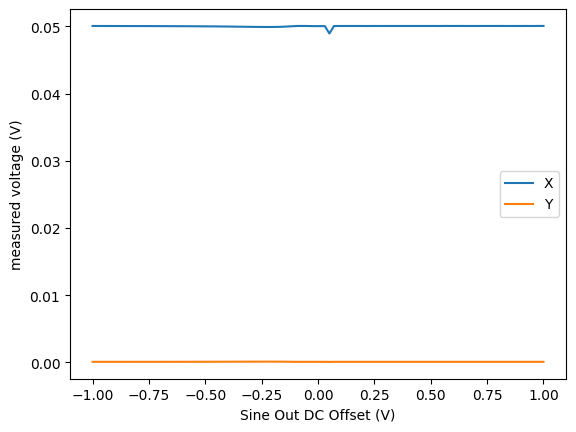

In [65]:
plt.plot(offset, X, label='X')
plt.plot(offset, Y, label='Y')
plt.xlabel('Sine Out DC Offset (V)')
plt.ylabel('measured voltage (V)')
plt.legend()